In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =4.06197e-22

nband = 340

ng =9

ng_refs = (/ 3 , 2 , 4 /) 

nref =3

nv = 200

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 30 , 300 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =294

vstar = 20

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66,
     &     1.66/

data wgt
     &     /0.3 , 0.3 , 0.3 , 0.3,
     &     0.3 , 0.3 , 0.6 , 0.6,
     &     0.6/

atmosphere_profiles/mls75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

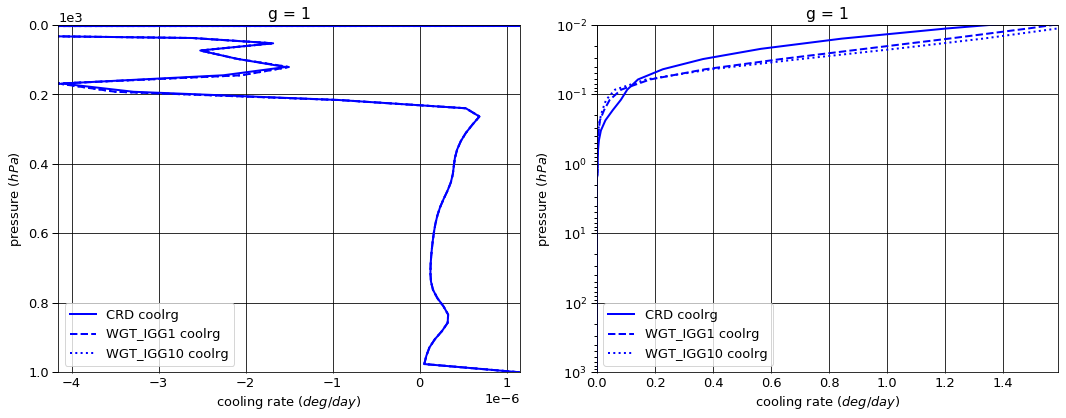

# Figure: cooling rate g-group 2

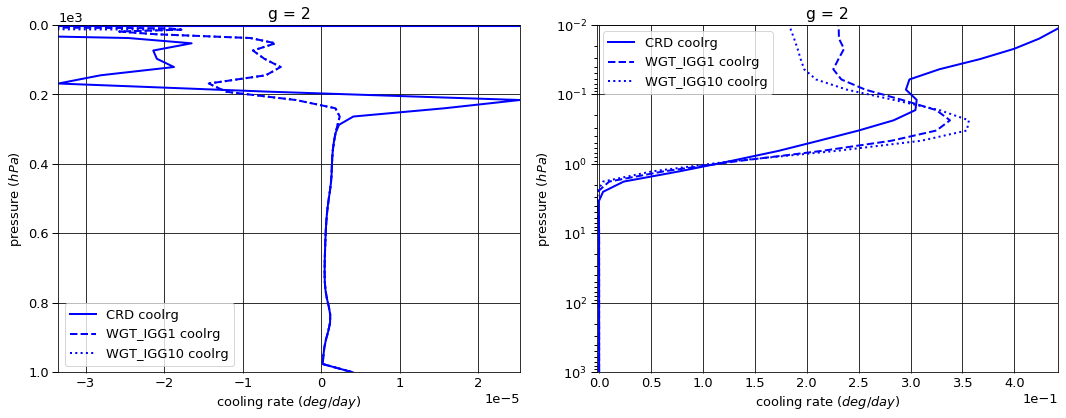

# Figure: cooling rate g-group 3

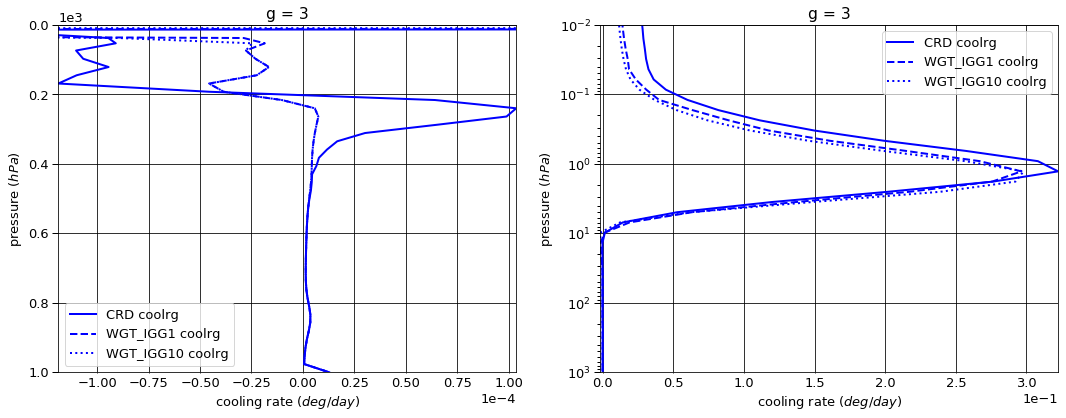

# Figure: cooling rate g-group 4

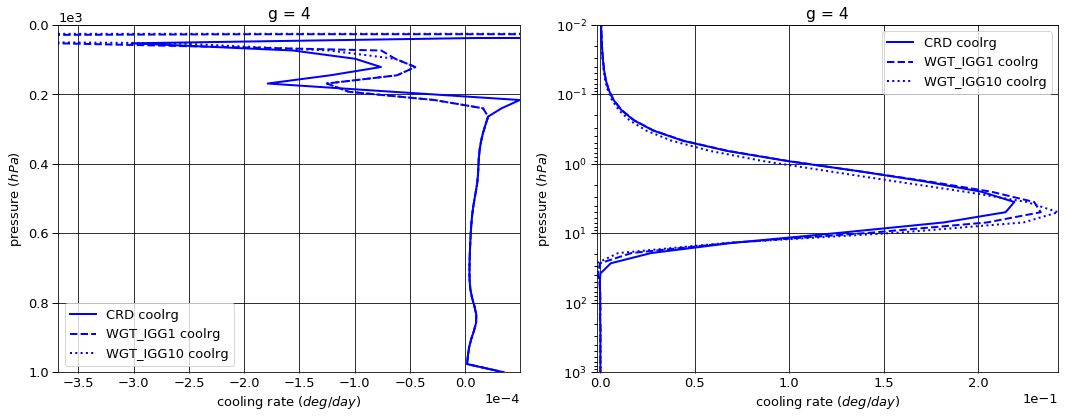

# Figure: cooling rate g-group 5

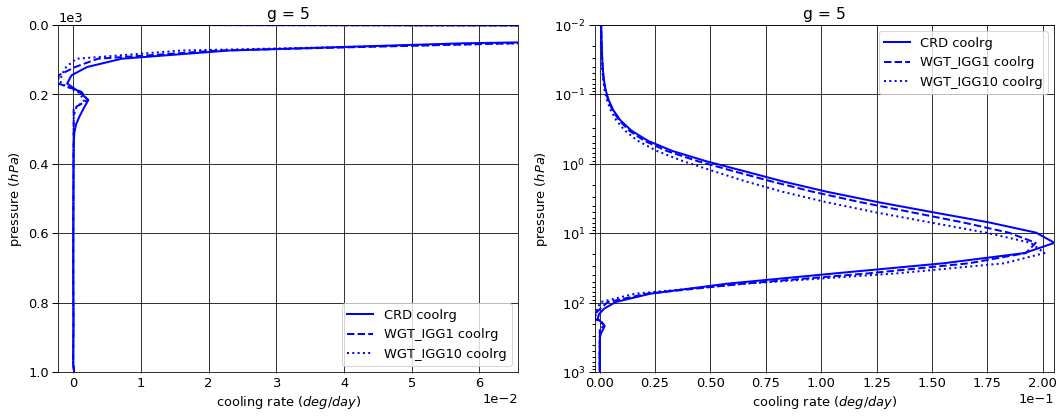

# Figure: cooling rate g-group 6

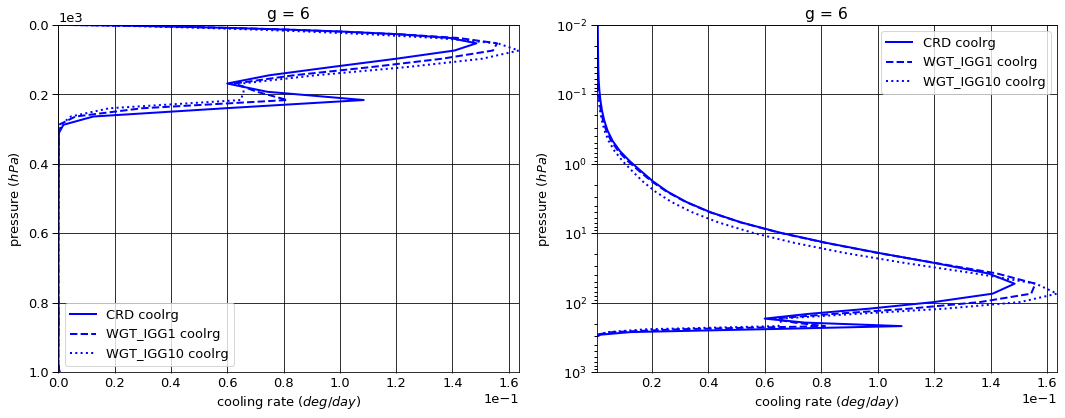

# Figure: cooling rate g-group 7

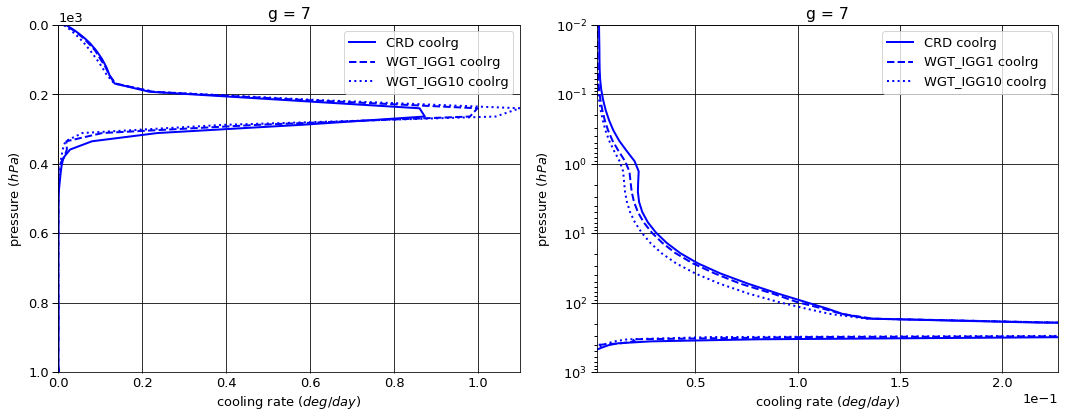

# Figure: cooling rate g-group 8

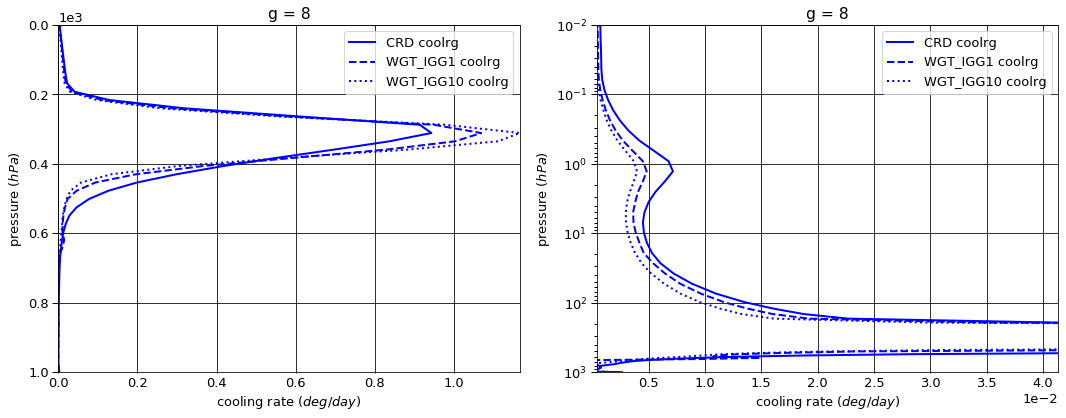

# Figure: cooling rate g-group 9

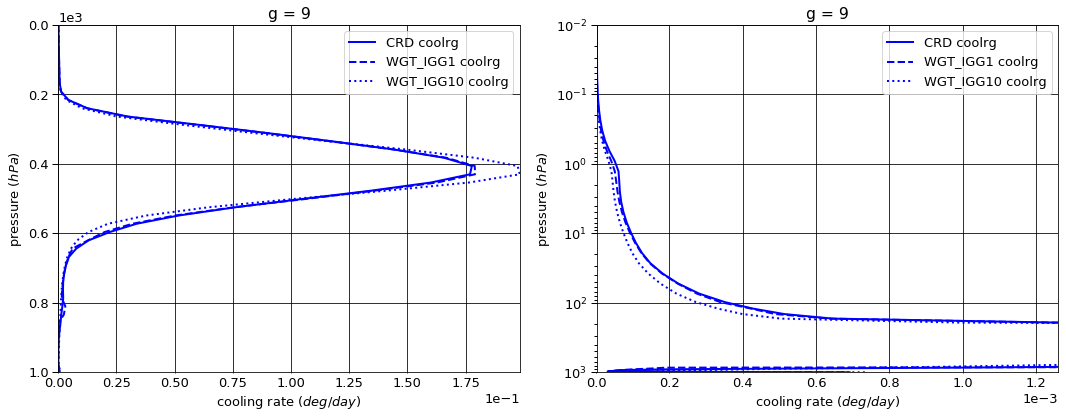

# Figure: cooling rate g-group total

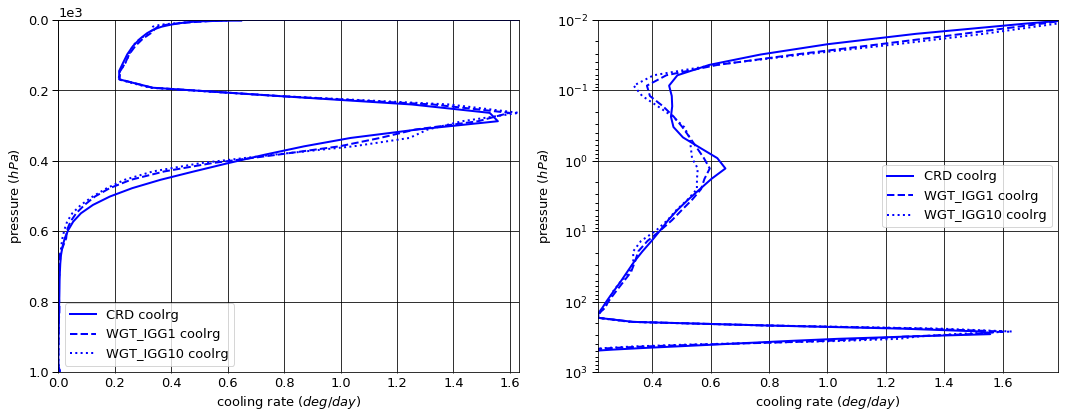

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.007541   0.000000  -0.007541
  1013.0   76     -0.012800   0.012797  -0.000003
2 0.0      1      -0.031944   0.000000  -0.031944
  1013.0   76     -0.043346   0.043335  -0.000011
3 0.0      1      -0.113180   0.000000  -0.113180
  1013.0   76     -0.138732   0.138696  -0.000035
4 0.0      1      -0.282656   0.000000  -0.282656
  1013.0   76     -0.385551   0.385455  -0.000096
5 0.0      1      -1.008569   0.000000  -1.008569
  1013.0   76     -1.575058   1.574663  -0.000395
6 0.0      1      -2.950014   0.000000  -2.950014
  1013.0   76     -4.904228   4.903002  -0.001226
7 0.0      1     -11.722628   0.000000 -11.722628
  1013.0   76    -18.371574  18.366946  -0.004629
8 0.0      1     -18.060444   0.000000 -18.060444
  1013.0   76    -26.402743  26.395462  -0.007280
9 0.0      1      -4.531384   0.000000  -4.531384
  1013.0   76     -6.297699   6.295787  -0.001912


WGT_IGG1


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.007438   0.000000  -0.007438
  1013.0   76     -0.012800   0.012797  -0.000003
2 0.0      1      -0.032423   0.000000  -0.032423
  1013.0   76     -0.043346   0.043335  -0.000011
3 0.0      1      -0.113245   0.000000  -0.113245
  1013.0   76     -0.138732   0.138696  -0.000035
4 0.0      1      -0.284852   0.000000  -0.284852
  1013.0   76     -0.385551   0.385455  -0.000096
5 0.0      1      -1.006728   0.000000  -1.006728
  1013.0   76     -1.575058   1.574663  -0.000395
6 0.0      1      -2.933857   0.000000  -2.933857
  1013.0   76     -4.904228   4.903002  -0.001226
7 0.0      1     -11.636360   0.000000 -11.636360
  1013.0   76    -18.371574  18.366946  -0.004629
8 0.0      1     -17.914679   0.000000 -17.914679
  1013.0   76    -26.402743  26.395462  -0.007280
9 0.0      1      -4.528912   0.000000  -4.528912
  1013.0   76     -6.297699   6.295798  -0.001901


WGT_IGG10


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.007420   0.000000  -0.007420
  1013.0   76     -0.012800   0.012797  -0.000003
2 0.0      1      -0.032414   0.000000  -0.032414
  1013.0   76     -0.043346   0.043335  -0.000011
3 0.0      1      -0.113770   0.000000  -0.113770
  1013.0   76     -0.138732   0.138696  -0.000035
4 0.0      1      -0.284976   0.000000  -0.284976
  1013.0   76     -0.385551   0.385455  -0.000096
5 0.0      1      -1.005534   0.000000  -1.005534
  1013.0   76     -1.575058   1.574663  -0.000395
6 0.0      1      -2.923201   0.000000  -2.923201
  1013.0   76     -4.904228   4.903002  -0.001226
7 0.0      1     -11.623058   0.000000 -11.623058
  1013.0   76    -18.371574  18.366946  -0.004629
8 0.0      1     -17.892836   0.000000 -17.892836
  1013.0   76    -26.402743  26.395462  -0.007280
9 0.0      1      -4.523124   0.000000  -4.523124
  1013.0   76     -6.297699   6.295798  -0.001901


WGT_IGG1 - CRD


flug      fldg         fnetg
g pressure level                                      
1 0.0      1      1.026332e-04  0.000000  1.026332e-04
  1013.0   76    -1.734723e-18  0.000000  0.000000e+00
2 0.0      1     -4.790110e-04  0.000000 -4.790110e-04
  1013.0   76     0.000000e+00  0.000000  0.000000e+00
3 0.0      1     -6.436000e-05  0.000000 -6.436000e-05
  1013.0   76     0.000000e+00  0.000000  0.000000e+00
4 0.0      1     -2.195640e-03  0.000000 -2.195640e-03
  1013.0   76     0.000000e+00  0.000000  0.000000e+00
5 0.0      1      1.840600e-03  0.000000  1.840600e-03
  1013.0   76    -2.220446e-16  0.000000 -5.421011e-20
6 0.0      1      1.615730e-02  0.000000  1.615730e-02
  1013.0   76     0.000000e+00  0.000000  2.168404e-19
7 0.0      1      8.626800e-02  0.000000  8.626800e-02
  1013.0   76     0.000000e+00  0.000000  0.000000e+00
8 0.0      1      1.457650e-01  0.000000  1.457650e-01
  1013.0   76     0.000000e+00  0.000000  0.000000e+00
9 0.0      1      2.471200e-03  0.000000  2.471200e-03
  1013.0   76     0.000000e+00  0.000012  1.159770e-05


WGT_IGG10 - CRD


flug      fldg         fnetg
g pressure level                                      
1 0.0      1      1.204099e-04  0.000000  1.204099e-04
  1013.0   76    -1.734723e-18  0.000000  0.000000e+00
2 0.0      1     -4.696390e-04  0.000000 -4.696390e-04
  1013.0   76     0.000000e+00  0.000000  0.000000e+00
3 0.0      1     -5.892000e-04  0.000000 -5.892000e-04
  1013.0   76     0.000000e+00  0.000000  0.000000e+00
4 0.0      1     -2.319820e-03  0.000000 -2.319820e-03
  1013.0   76     0.000000e+00  0.000000  0.000000e+00
5 0.0      1      3.035100e-03  0.000000  3.035100e-03
  1013.0   76    -2.220446e-16  0.000000 -5.421011e-20
6 0.0      1      2.681360e-02  0.000000  2.681360e-02
  1013.0   76     0.000000e+00  0.000000  2.168404e-19
7 0.0      1      9.957000e-02  0.000000  9.957000e-02
  1013.0   76     0.000000e+00  0.000000  0.000000e+00
8 0.0      1      1.676080e-01  0.000000  1.676080e-01
  1013.0   76     0.000000e+00  0.000000  0.000000e+00
9 0.0      1      8.260100e-03  0.000000  8.260100e-03
  1013.0   76     0.000000e+00  0.000012  1.159740e-05

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1      4.811304
  1001.112500 75     0.000001
2 0.000312    1      0.445643
  1001.112500 75     0.000004
3 0.000312    1      0.022939
  1001.112500 75     0.000013
4 0.000312    1      0.000012
  1001.112500 75     0.000035
5 0.000312    1      0.000454
  1001.112500 75     0.000143
6 0.000312    1      0.000740
  1001.112500 75     0.000443
7 0.000312    1      0.002675
  1001.112500 75     0.001674
8 0.000312    1      0.000565
  1001.112500 75     0.002632
9 0.000312    1      0.000002
  1001.112500 75     0.000692


WGT_IGG1


coolrg
g pressure    layer          
1 0.000312    1      2.653217
  1001.112500 75     0.000001
2 0.000312    1      0.200413
  1001.112500 75     0.000004
3 0.000312    1      0.010413
  1001.112500 75     0.000013
4 0.000312    1      0.000013
  1001.112500 75     0.000035
5 0.000312    1      0.000410
  1001.112500 75     0.000143
6 0.000312    1      0.000422
  1001.112500 75     0.000443
7 0.000312    1      0.001852
  1001.112500 75     0.001674
8 0.000312    1      0.000380
  1001.112500 75     0.002632
9 0.000312    1      0.000001
  1001.112500 75     0.000687


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      2.250981e+00
  1001.112500 75     1.151479e-06
2 0.000312    1      1.529486e-01
  1001.112500 75     4.009439e-06
3 0.000312    1      8.633288e-03
  1001.112500 75     1.274965e-05
4 0.000312    1      1.149280e-05
  1001.112500 75     3.478263e-05
5 0.000312    1      3.568672e-04
  1001.112500 75     1.430010e-04
6 0.000312    1      3.583247e-04
  1001.112500 75     4.432052e-04
7 0.000312    1      1.517686e-03
  1001.112500 75     1.673751e-03
8 0.000312    1      3.029564e-04
  1001.112500 75     2.632163e-03
9 0.000312    1      9.248198e-07
  1001.112500 75     7.406008e-04


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.158086e+00
  1001.112500 75     0.000000e+00
2 0.000312    1     -2.452301e-01
  1001.112500 75     0.000000e+00
3 0.000312    1     -1.252682e-02
  1001.112500 75     0.000000e+00
4 0.000312    1      5.926370e-07
  1001.112500 75     0.000000e+00
5 0.000312    1     -4.469542e-05
  1001.112500 75     0.000000e+00
6 0.000312    1     -3.176681e-04
  1001.112500 75     0.000000e+00
7 0.000312    1     -8.229792e-04
  1001.112500 75     0.000000e+00
8 0.000312    1     -1.848715e-04
  1001.112500 75     0.000000e+00
9 0.000312    1     -3.405032e-07
  1001.112500 75    -4.747170e-06


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.560323e+00
  1001.112500 75     0.000000e+00
2 0.000312    1     -2.926947e-01
  1001.112500 75     0.000000e+00
3 0.000312    1     -1.430614e-02
  1001.112500 75     0.000000e+00
4 0.000312    1     -9.304500e-07
  1001.112500 75     0.000000e+00
5 0.000312    1     -9.740192e-05
  1001.112500 75     0.000000e+00
6 0.000312    1     -3.812626e-04
  1001.112500 75     0.000000e+00
7 0.000312    1     -1.156939e-03
  1001.112500 75     0.000000e+00
8 0.000312    1     -2.617220e-04
  1001.112500 75     0.000000e+00
9 0.000312    1     -6.196567e-07
  1001.112500 75     4.881082e-05

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-38.708360,0.000000,-38.708360
1013.0,76,-58.131732,58.116144,-0.015588



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-38.458494,0.000000,-38.458494
1013.0,76,-58.131732,58.116155,-0.015576



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-38.406332,0.000000,-38.406332
1013.0,76,-58.131732,58.116155,-0.015576



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.249866,0.000000,0.249866
1013.0,76,0.000000,0.000012,0.000012



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.302029,0.000000,0.302029
1013.0,76,0.000000,0.000012,0.000012


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,5.284334
1001.112500,75,0.005637



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,2.867120
1001.112500,75,0.005632



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,2.415111
1001.112500,75,0.005685



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-2.417213
1001.112500,75,-0.000005



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-2.869222
1001.112500,75,0.000049


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000279,0.000225
2,0.000838,0.000756
3,0.002750,0.002425
4,0.008250,0.006779
5,0.032956,0.027640
6,0.105132,0.086193
7,0.378838,0.322063
8,0.391471,0.449921
9,0.079485,0.103997


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,7.222796e-17
2,5.686282e-18
3,4.476633e-19
4,1.008726e-18
5,8.035412e-20
6,6.290914e-20
7,5.055345e-21
8,4.062448e-22
9,1.632043e-22


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,7.222796e-17,NaN,0.000279,0.000225,0.000279,0.000225,1.0
2,5.686282e-18,0.078727,0.000838,0.000756,0.001118,0.000981,1.0
3,4.476633e-19,0.078727,0.002750,0.002425,0.003868,0.003407,1.0
4,1.008726e-18,2.253314,0.008250,0.006779,0.012118,0.010186,30.0
5,8.035412e-20,0.079659,0.032956,0.027640,0.045074,0.037826,30.0
6,6.290914e-20,0.782899,0.105132,0.086193,0.150206,0.124019,300.0
7,5.055345e-21,0.080359,0.378838,0.322063,0.529044,0.446082,300.0
8,4.062448e-22,0.080359,0.391471,0.449921,0.920515,0.896003,300.0
9,1.632043e-22,0.401739,0.079485,0.103997,1.000000,1.000000,300.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     3.385914e-16  1.082233e-16   3.128637  1.510194e-02
      2 0.000312     1.022631e-17  3.445947e-18   2.967635  4.666879e-04
      3 0.000312     2.381652e-19  7.012247e-20   3.396417  1.026492e-05
      4 0.000312     4.272615e-23  4.272238e-23   1.000088  3.638383e-09
      5 0.000312     3.577326e-22  2.140411e-22   1.671327  2.189906e-08
      6 0.000312     1.436945e-22  4.612235e-23   3.115507  6.420640e-09
      7 0.000312     1.456024e-22  1.457145e-23   9.992309  7.936169e-09
      8 0.000312     2.797355e-23  1.126341e-24  24.835771  1.467724e-09
      9 0.000312     4.203030e-25  1.927816e-25   2.180203  2.804309e-11
2     1 0.000750     3.391023e-16  1.084560e-16   3.126636  6.093705e-03
      2 0.000750     1.027338e-17  3.460134e-18   2.969071  1.888007e-04
      3 0.000750     2.393947e-19  7.092162e-20   3.375482  4.166415e-06
      4 0.000750     9.491101e-23  9.490477e-23   1.000066  3.255466e-09
      5 0.000750     3.642449e-22  2.195142e-22   1.659323  9.019082e-09
      6 0.000750     1.440954e-22  4.657436e-23   3.093878  2.601127e-09
      7 0.000750     1.459764e-22  1.465286e-23   9.962311  3.205396e-09
      8 0.000750     2.810020e-23  1.133619e-24  24.788053  5.938862e-10
      9 0.000750     4.231490e-25  1.941051e-25   2.179999  1.137212e-11
3     1 0.001052     3.401761e-16  1.088408e-16   3.125446  8.574181e-03
      2 0.001052     1.036818e-17  3.480889e-18   2.978602  2.668384e-04
      3 0.001052     2.413230e-19  7.183027e-20   3.359628  5.901345e-06
      4 0.001052     1.310551e-22  1.310459e-22   1.000070  6.304008e-09
      5 0.001052     3.716567e-22  2.247283e-22   1.653804  1.293077e-08
      6 0.001052     1.445163e-22  4.706922e-23   3.070294  3.670521e-09
      7 0.001052     1.467180e-22  1.476287e-23   9.938310  4.518725e-09
      8 0.001052     2.836672e-23  1.143521e-24  24.806469  8.407402e-10
      9 0.001052     4.287651e-25  1.963744e-25   2.183406  1.615385e-11
4     1 0.001476     3.413099e-16  1.092658e-16   3.123665  1.207168e-02
      2 0.001476     1.047012e-17  3.504356e-18   2.987743  3.775176e-04
      3 0.001476     2.435061e-19  7.292518e-20   3.339122  8.374871e-06
      4 0.001476     1.817571e-22  1.817422e-22   1.000082  1.226521e-08
      5 0.001476     3.806563e-22  2.313348e-22   1.645478  1.863476e-08
      6 0.001476     1.450393e-22  4.767412e-23   3.042306  5.188506e-09
      7 0.001476     1.475257e-22  1.488988e-23   9.907789  6.375418e-09
      8 0.001476     2.865307e-23  1.154967e-24  24.808561  1.191372e-09
      9 0.001476     4.348702e-25  1.988960e-25   2.186421  2.297738e-11
5     1 0.002070     3.424422e-16  1.097200e-16   3.121057  1.699383e-02
      2 0.002070     1.057431e-17  3.530320e-18   2.995284  5.341803e-04
      3 0.002070     2.459080e-19  7.423765e-20   3.312444  1.190165e-05
      4 0.002070     2.528810e-22  2.528551e-22   1.000103  2.393443e-08
      5 0.002070     3.915103e-22  2.397173e-22   1.633217  2.700049e-08
      6 0.002070     1.456864e-22  4.841038e-23   3.009404  7.344489e-09
      7 0.002070     1.483639e-22  1.503414e-23   9.868465  8.995138e-09
      8 0.002070     2.894456e-23  1.167980e-24  24.781733  1.688049e-09
      9 0.002070     4.411962e-25  2.016011e-25   2.188461  3.268946e-11
6     1 0.002904     3.435724e-16  1.102143e-16   3.117313  2.392884e-02
      2 0.002904     1.068128e-17  3.559775e-18   3.000549  7.563133e-04
      3 0.002904     2.486045e-19  7.585322e-20   3.277442  1.695246e-05
      4 0.002904     3.526676e-22  3.526201e-22   1.000135  4.682084e-08
      5 0.002904     4.049320e-22  2.505832e-22   1.615958  3.941912e-08
      6 0.002904     1.465056e-22  4.932928e-23   2.969953  1.042043e-08
      7 0.002904     1.492386e-22  1.520237e-23   9.816797  1.269644e-08
      8 0.002904     2.924150e-23  1.183160e-24  24.714741  2.392352e-09
      9 0.0

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
